In [46]:
import pandas as pd 
import numpy as np 
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import mysql.connector
# df1 =pd.read_parquet('./cleanedFeatures.parquet',engine='pyarrow')
# df1

In [211]:
try:
    connection = mysql.connector.connect(host='localhost',
                                             database='project1',
                                             user='root',
                                             password='MosiSQL$$')
   
    #AllPlayersFeature
    cursor = connection.cursor()
    cursor.execute('select * from playersfeature')
    record = cursor.fetchall()
    df1=pd.DataFrame(record ,columns=[i[0] for i in cursor.description])
    
    
except mysql.connector.Error as error:
    print("Failed to get record from database: {}".format(error))

finally:
    if connection.is_connected():
        cursor.close()
        connection.close()
        df=df1.drop(columns='id')
        print("MySQL connection is closed")



MySQL connection is closed


In [ ]:
# Just Run This Section And Let Be Done Ignore All Warnings ('_')
#DataCleaning Techniques
df1 = df.dropna()
deletedPosition = ['LIAN Sports Group','LB SPORT & ...','2SAgency','Gelu Rodríguez','SPOCS Global Sports','ROGON','FIRST'\
   'Playeleven', 'Wasserman','Unique Sports Group','SMI Sports ...','CAA Stellar','GG11','InterStarDeporte','YOU FIRST','SEG'\
      'Playeleven','FIRST'] 
df1 = df1.drop(df1[df1['position'].isin(deletedPosition)].index)

len(df1)
dfML = df1[['playersId','age','height','position','currentValue','squad','appearances','ppg','goals',\
    'assists','ownGoal','subsituationsOn','subsituationsOff','yellowCards','secondYellowCards'\
        ,'redCards','penalyGoals','minutesPerGoal','minutesPlayed','goalsConceded','cleanSheets']]

def changeSquad(x):
    if str(x)=='-':
        return 0
    else: return np.int64(x)
dfML['squad'] = dfML['squad'].apply(lambda x: changeSquad(x))

def changeAppearances(x):
    if str(x)=='-':
        return 0
    else : return np.int64(x)
dfML['appearances'] = dfML['appearances'].apply(lambda x: changeAppearances(x))


def changePPG(x):
    if str(x)=='-' or str(x)=='0,00':
        return 0
    else : return  np.float64(x)
dfML['ppg'] = dfML['ppg'].apply(lambda x: changePPG(x))


def changeGoals(x):
    if str(x)=='-' or str(x)=='0,00':
        return 0
    else : return  np.float64(x)
dfML['goals'] = dfML['goals'].apply(lambda x: changeGoals(x))


def changeAssists(x):
    if str(x)=='-' or str(x)=='goalKeeper' :
        return 0
    else : return  np.float64(x)
dfML['assists'] = dfML['assists'].apply(lambda x: changeAssists(x))



def changeOwngoal(x):
    if str(x)=='-' :
        return 0
    else : return  np.float64(x)
dfML['ownGoal'] = dfML['ownGoal'].apply(lambda x: changeAssists(x))


def changeSubsituationsOn(x):
    if str(x)=='-' :
        return 0
    else : return  np.float64(x)
dfML['subsituationsOn'] = dfML['subsituationsOn'].apply(lambda x: changeSubsituationsOn(x))


def changeSubsituationsOff(x):
    try:
        return np.float64(x)
    except:
        return 0 
dfML['subsituationsOff'] = dfML['subsituationsOff'].apply(lambda x: changeSubsituationsOff(x))


def changeYellowCards(x):
    try:
        return np.float64(x)
    except:
        return 0 
dfML['yellowCards'] = dfML['yellowCards'].apply(lambda x: changeYellowCards(x))


def changeAll(x):
    try:
        return np.float64(x)
    except:
        return 0 
dfML['secondYellowCards'] = dfML['secondYellowCards'].apply(lambda x: changeAll(x))

def changeMinute(x):
    try:
        return np.float64(str(x).replace("'","").replace('.',''))
    except:
        return 0 
dfML['redCards'] = dfML['redCards'].apply(lambda x: changeAll(x))
dfML['penalyGoals'] = dfML['penalyGoals'].apply(lambda x: changeAll(x))
dfML['minutesPerGoal'] = dfML['minutesPerGoal'].apply(lambda x: changeMinute(x))
dfML['minutesPlayed'] = dfML['minutesPlayed'].apply(lambda x: changeMinute(x))
dfML['goalsConceded'] = dfML['goalsConceded'].apply(lambda x: changeAll(x))
dfML['cleanSheets'] = dfML['cleanSheets'].apply(lambda x: changeAll(x))
dfML = dfML.drop(labels = dfML[dfML['position'].isin(['Playeleven','SEG'])].index)
finalDf = pd.DataFrame(dfML.groupby('playersId').sum())
finalDf=finalDf.reset_index()
def changeValue(x):
    if x!=np.nan and x!=None:
        if('k' in str(x)):
            try:
                return np.float64(str(x).replace('k','').replace('€',''))/1000
            except:
                #â‚¬400k
                return(0.4)
        else :
            try:
                return np.float64(str(x).replace('m','').replace('€',''))
            except:
                #â‚¬400k
                return 0.4
    else :
        return np.nan
def changeHeight(x):
    try:
        return np.float64(str(x).replace(',','.').replace('m',''))
    except:
        return 0
def changeAge(x):
    try:
        return np.int64(x)
    except:
        return 0


dfML['height'] = dfML['height'].apply(lambda x : changeHeight(x))
dfML['age'] = dfML['age'].apply(lambda x : changeAge(x))
height = pd.DataFrame(dfML.groupby('playersId')['height'].agg(['unique'])).reset_index()
age = pd.DataFrame(dfML.groupby('playersId')['age'].agg(['unique'])).reset_index()
position = pd.DataFrame(dfML.groupby('playersId')['position'].agg(['unique'])).reset_index()
position['position'] = position['unique'].apply(lambda x : x[0])
height['height'] = height['unique'].apply(lambda x : x[0])
age['age'] = age['unique'].apply(lambda x : x[0])
dfML['currentValue']=dfML['currentValue'].apply(lambda x : changeValue(x))
value = pd.DataFrame(dfML.groupby('playersId')['currentValue'].agg(['unique'])).reset_index()
value['marketValue']=value['unique'].apply(lambda x : x[0])
finalDf = pd.merge(finalDf,value ,on='playersId').drop(columns=['unique'])
finalDf = pd.merge(finalDf,height ,on='playersId').drop(columns=['unique'])
finalDf = pd.merge(finalDf,age  ,on='playersId').drop(columns=['unique'])
finalDf = pd.merge(finalDf,position  ,on='playersId').drop(columns=['unique'])
# finalDf = pd.get_dummies(finalDf, columns = ['position'])
# finalDf
df1 =finalDf



In [213]:
label = LabelEncoder()

df1['position'] = label.fit_transform(df1['position'])
df1
data= df1.iloc[:, 1:]
# data  = data.drop(columns='ppg')
# data = data[['squad','appearances','goals','ownGoal','marketValue','position','age']]

In [ ]:
# we checked this section too there is no improvment happened when we delete outliers from our data 
# def remove_outliers(df,columns,n_std):
#     for col in columns:
#         print('Working on column: {}'.format(col))
        
#         mean = df[col].mean()
#         sd = df[col].std()
        
#         df = df[(df[col] <= mean+(n_std*sd))]
#         print('Job done on column: {}'.format(col))
        
#     return df
# df  = remove_outliers(df1.drop(columns='playersId'),df1.drop(columns='playersId').columns.tolist(),3)

In [216]:
#Feature selection using mutual information and chi2   
# Actually we ignore this section . why?! because we try with such a different parameters and no improvment seen
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile ,mutual_info_classif
data= df1.iloc[:, 1:]
# feature scaling
scaler = MinMaxScaler()
standard = StandardScaler()
scaled = scaler.fit_transform(data)

# feature selection
# selector = SelectKBest(chi2, k=20)
# selector = SelectPercentile(chi2, percentile=80)

# selected = selector.fit_transform(data, df1['position'])

# print('Number of features before selection:', data.shape[1])
# print('Number of features after selection:', selected.shape[1])
# data = pd.DataFrame(selected)


In [33]:
# from sklearn.preprocessing import StandardScaler
# standard = StandardScaler()

# data = pd.DataFrame(standard.fit_transform(data), columns = data.columns)

In [217]:
from sklearn.cluster import KMeans
cost = []
for i in range(1,21):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0, n_init=5)
    kmeans.fit(data)
    cost.append(kmeans.inertia_)

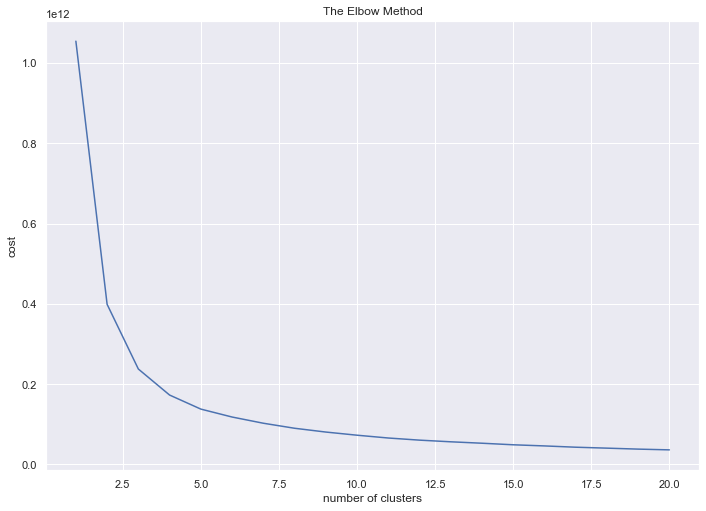

In [218]:
plt.plot(range(1,21), cost)
plt.title('The Elbow Method')
plt.xlabel('number of clusters')
plt.ylabel('cost')
plt.show()

In [219]:
kmeans_cluster = KMeans(n_clusters= 3, init='k-means++', random_state=0)
kmeans_cluster_pred = kmeans_cluster.fit_predict(data)

C:\Users\mosta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [220]:
len(kmeans_cluster_pred)

7359

In [221]:
from mpl_toolkits import mplot3d
kmeans_cluster.cluster_centers_


array([[3.60941133e+02, 2.95754098e+02, 4.50560805e+01, 3.67645306e+01,
        2.35175112e+01, 6.28166915e-01, 6.00491803e+01, 7.03349478e+01,
        4.01743666e+01, 1.16766021e+00, 1.23658718e+00, 3.08383010e+00,
        6.12734165e+03, 2.11596833e+04, 7.27906110e+00, 2.86277943e+01,
        5.60099665e+00, 1.82401267e+00, 2.89858420e+01, 5.56445604e+00],
       [5.57805581e+02, 4.83988837e+02, 6.97587721e+01, 5.67795349e+01,
        4.06269767e+01, 1.29581395e+00, 6.49274419e+01, 8.78111628e+01,
        6.96251163e+01, 1.92279070e+00, 2.02604651e+00, 5.55813953e+00,
        1.10790242e+04, 3.75084493e+04, 1.68465116e+01, 6.12920930e+01,
        5.12248837e+00, 1.82858605e+00, 3.34883721e+01, 5.26139535e+00],
       [1.74901667e+02, 1.29569444e+02, 2.27741306e+01, 1.51102778e+01,
        8.61361111e+00, 2.22222222e-01, 3.41138889e+01, 3.36916667e+01,
        1.64605556e+01, 4.71944444e-01, 5.58333333e-01, 1.19777778e+00,
        2.46137417e+03, 8.62395139e+03, 3.32805556e+00, 1.4808

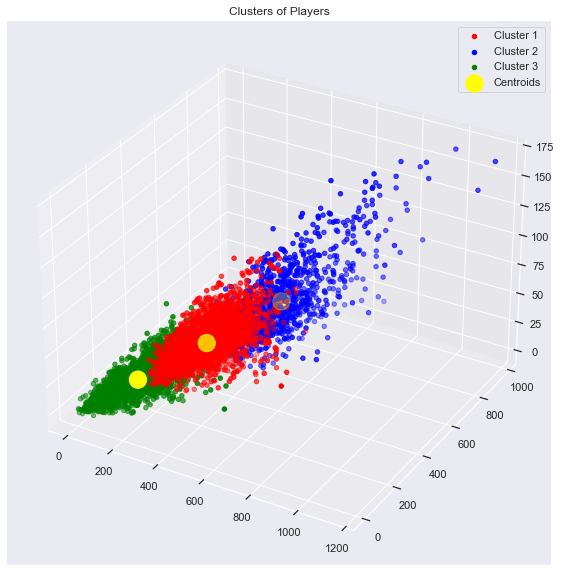

In [246]:
#Visualizing all the clusters 
data = pd.DataFrame(data)
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')

ax.scatter3D(data.iloc[kmeans_cluster_pred == 0, 0], data.iloc[kmeans_cluster_pred == 0, 1], data.iloc[kmeans_cluster_pred == 0, 2], \
             label = 'Cluster 1', c = 'red' )

ax.scatter3D(data.iloc[kmeans_cluster_pred == 1, 0], data.iloc[kmeans_cluster_pred == 1, 1], data.iloc[kmeans_cluster_pred == 1, 2], \
             label = 'Cluster 2', c = 'blue')

ax.scatter3D(data.iloc[kmeans_cluster_pred == 2, 0], data.iloc[kmeans_cluster_pred == 2, 1], data.iloc[kmeans_cluster_pred == 2, 2], \
             label = 'Cluster 3', c = 'green')

ax.scatter3D(data.iloc[kmeans_cluster_pred == 3, 0], data.iloc[kmeans_cluster_pred == 3, 1], data.iloc[kmeans_cluster_pred == 3, 2], \
             label = '', c = 'black')

ax.scatter3D(data.iloc[kmeans_cluster_pred == 4, 0], data.iloc[kmeans_cluster_pred == 4, 1], data.iloc[kmeans_cluster_pred == 4, 2], \
             label = '', c = 'magenta')

ax.scatter3D(kmeans_cluster.cluster_centers_[:, 0], kmeans_cluster.cluster_centers_[:, 1], kmeans_cluster.cluster_centers_[:, 2]\
            ,s = 300, c = 'yellow', label = 'Centroids')

plt.title('Clusters of Players')

plt.legend()
plt.show()



In [223]:
np.unique(kmeans_cluster_pred)
# sklearn.metrics.silhouette_score
from sklearn.metrics import silhouette_score,davies_bouldin_score
print('silhouette_score : ',silhouette_score(data.values,kmeans_cluster_pred))
print('davies_bouldin_score : ',davies_bouldin_score(data.values,kmeans_cluster_pred))

silhouette_score :  0.4937651326618963
davies_bouldin_score :  0.7103259202175347


In [227]:
#Deploy DBSCAN 
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
X = df1.drop(columns=['playersId','marketValue']).values
# X=data
db = DBSCAN(eps=2200, min_samples=4).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 32


In [228]:
len(labels)

7359

In [229]:
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

Silhouette Coefficient: 0.655


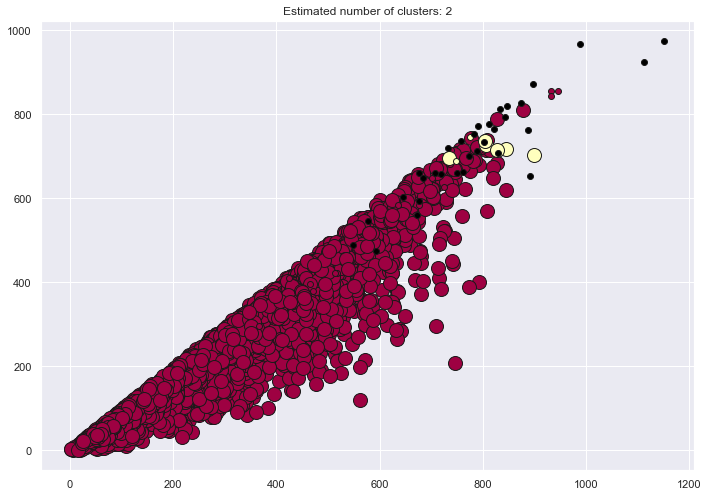

In [230]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [231]:
from sklearn.decomposition import PCA
# df = pd.read_parquet('./cleanedFeatures.parquet',engine='pyarrow')
# df['position'] = label.fit_transform(df['position'])
df=df1
df = df1.drop(columns = 'playersId')
# df = remove_outliers(df,df.columns.tolist(),3)
decompo = PCA(n_components=0.99)
df = decompo.fit_transform(df)
df= pd.DataFrame(df,columns={'x','y'})


In [233]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors = 5).fit(df)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(df)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis = 0)

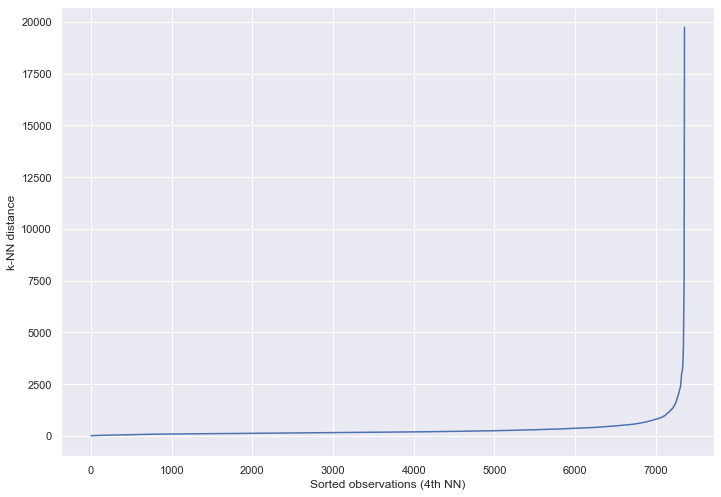

In [234]:
import matplotlib.pyplot as plt
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [236]:
from kneed import KneeLocator
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)

# get the estimate of knee point
print(kneedle.knee_y)

3287.742562413252


In [237]:
from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps = 3287.742562413252, min_samples = 4).fit(df)
# get cluster labels
clusters.labels_
# output
# array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

# check unique clusters
set(clusters.labels_)
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}
# -1 value represents noisy points could not assigned to any cluster

{-1, 0}

In [238]:
from collections import Counter
Counter(clusters.labels_)

Counter({0: 7345, -1: 14})

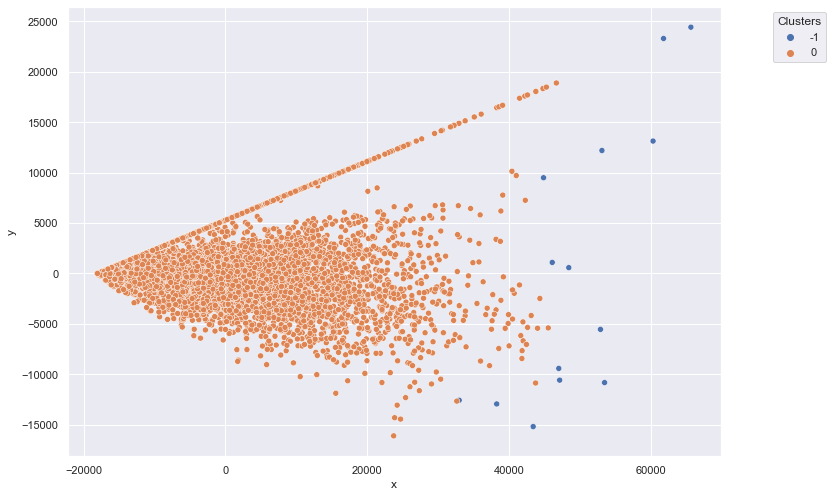

In [239]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})
p = sns.scatterplot(data = df,x='x',y='y', hue = clusters.labels_, legend = "full", palette = "deep")
sns.move_legend(p, "upper right", bbox_to_anchor = (1.17, 1.), title = 'Clusters')
plt.show()


In [132]:
from sklearn import metrics

print(f"Silhouette Coefficient: {metrics.silhouette_score(df, clusters.labels_):.3f}")
print('davies_bouldin_score : ',davies_bouldin_score(df,clusters.labels_))

Silhouette Coefficient: 0.707
davies_bouldin_score :  0.4732984343375924
